<a href="https://colab.research.google.com/github/vjihye/TIL/blob/master/3_14__A_Temperature_forecasting_problem_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Inspecting the data of the Jena weather dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq "/content/drive/MyDrive/jena_climate_2009_2016.csv.zip"

In [3]:
import os

In [6]:
fname = 'jena_climate_2009_2016.csv'

In [7]:
f=open(fname)
data = f.read()
f.close()

In [8]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [9]:
print(header)
print(len(header))
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


### Parsing the data

In [10]:
import numpy as np

In [11]:
float_data = np.zeros((len(lines), len(header) -1))

In [12]:
for i , line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

### Plotting the Temperature time-series

In [13]:
from matplotlib import pyplot as plt

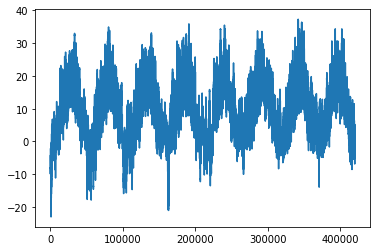

In [14]:
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

### Plotting the first 10-days of Temperature time-series

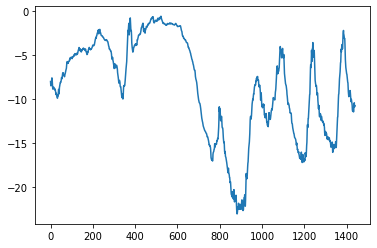

In [15]:
plt.plot(range(1440), temp[:1440])

### Preparing the data
#### • 각 시계열 특성에 대해 평균을 빼고 표준편차로 나눠 전처리 함
#### • 처음 20만개 타임스텝을 훈련 데이터로 사용 → 전체 데이터에서 20만개만 사용하여 평균과 표준편차 계산

In [18]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean

std = float_data[:200000].std(axis = 0)
float_data /= std

### Generator yielding timeseries samples and targets

In [36]:
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)

    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets


### • 훈련 제너레이터 - 처음 20만개 타임스텝을 사용
### • 검증 제너레이터 - 그 다음 10만개 타임스텝을 사용
### • 테스트 제너레이터 - 나머지 타임스텝을 사용

In [52]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index = 0,
                      max_index = 200000, shuffle = True, step = step,
                      batch_size = batch_size)

In [53]:
val_gen = generator(float_data, 
                    lookback = lookback,
                    delay = delay, 
                    min_index = 200001,
                    max_index = 300000, 
                    step = step,
                    batch_size = batch_size)

test_gen = generator(float_data, lookback = lookback,
                     delay = delay,
                     min_index = 300001,
                     max_index = None,
                     step = step, batch_size = batch_size)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

### A common-sense, non-machine-learning baseline(상식수준으로 해법 시도, 정상여부확인)
#### • 온도 시계열 데이터가 연속성이 있고 일자별로 주기성을 가진다고 가정 → 오늘 온도는 내일 온도와 비슷할 가능성이 높음 → 지금으로부터 24시간 후 온도는 지금과 동일하다고 예측
#### • 이 방법을 평균 **절대값 오차(Mean Absolute Error)**로 평가

In [40]:
def evaluate_naive_method():
  batch_maes = []

  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))

evaluate_naive_method()

0.2896991739131649


#### • 계산된 MAE는 0.29 (평균이 0이고 표준편차가 1) 
#### → MAE에 표준 편차를 곱하면 섭씨 2.57℃(평균절대값 오차가 상당히 크다)

In [43]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

In [45]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

In [54]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps = val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


500/500 [==============================] - 809s 2s/step - loss: 1.1951 - val_loss: 0.5520
Epoch 2/20
500/500 [==============================] - 775s 2s/step - loss: 0.3963 - val_loss: 0.3167
Epoch 3/20
500/500 [==============================] - 772s 2s/step - loss: 0.2806 - val_loss: 0.3072
Epoch 4/20
500/500 [==============================] - 808s 2s/step - loss: 0.2608 - val_loss: 0.3158
Epoch 5/20
500/500 [==============================] - 808s 2s/step - loss: 0.2508 - val_loss: 0.3323
Epoch 6/20
500/500 [==============================] - 808s 2s/step - loss: 0.2406 - val_loss: 0.3223
Epoch 7/20
500/500 [==============================] - 808s 2s/step - loss: 0.2341 - val_loss: 0.3514
Epoch 8/20
500/500 [==============================] - 775s 2s/step - loss: 0.2290 - val_loss: 0.3242
Epoch 9/20
500/500 [==============================] - 775s 2s/step - loss: 0.2241 - val_loss: 0.3387
Epoch 10/20
500/500 [==============================] - 808s 2s/step - loss: 0.2207 - val_loss: 0.3489


In [55]:
import matplotlib.pyplot as plt

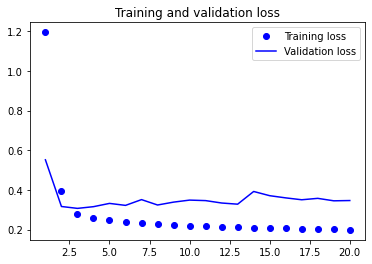

In [56]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### • 앞선 모델은 시계열 데이터를 펼쳤기 때문에 입력 데이터에서 시간 개념을 잃어버림 → 인과 관계와 순서가 의미가 있는 시퀀스 데이터를 그대로 사용